# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [110]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


In [111]:
df = pd.read_csv('data/zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [113]:
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


### Filtering for 5-digit Zipcodes

In [114]:
#Check RegionName column to see how many rows have more than 5 characters/digits
df[df['RegionName'] > 9999]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14716,99032,97028,Rhododendron,OR,Portland,Clackamas,14717,136200.0,136600.0,136800.0,...,332600,332900,335600,338900,340500,341000,342300,345000,348000,349300
14717,62697,12720,Bethel,NY,NaN,Sullivan,14718,62500.0,62600.0,62700.0,...,122200,122700,122300,122000,122200,122800,123200,123200,120700,117700
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


Original dataset had 14,723 rows, but taking an initial look into the dataset, we see some rows within the 'RegionName' have only 4 digits. After some research, we see that this column represents Zipcodes. US zipcodes are 5-digits long, therefore we can conclude that these rows have invalid zipcodes inputted. Let's filter the dataset to rows that have greater than 4-digits within that column.

In [115]:
#Filter dataset to ensure rows in the 'RegionName' column are more than 4 digits
df = df[df['RegionName'] > 9999]

In [116]:
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14716,99032,97028,Rhododendron,OR,Portland,Clackamas,14717,136200.0,136600.0,136800.0,...,332600,332900,335600,338900,340500,341000,342300,345000,348000,349300
14717,62697,12720,Bethel,NY,NaN,Sullivan,14718,62500.0,62600.0,62700.0,...,122200,122700,122300,122000,122200,122800,123200,123200,120700,117700
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


In [117]:
#Double check to see if there are any rows with more than 5 digits
df[df['RegionName'] > 99999]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04


In [118]:
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14716,99032,97028,Rhododendron,OR,Portland,Clackamas,14717,136200.0,136600.0,136800.0,...,332600,332900,335600,338900,340500,341000,342300,345000,348000,349300
14717,62697,12720,Bethel,NY,NaN,Sullivan,14718,62500.0,62600.0,62700.0,...,122200,122700,122300,122000,122200,122800,123200,123200,120700,117700
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


# Queens, NY County Test

In [119]:
queens = df[df['CountyName'] == 'Queens']
queens

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
12,62087,11375,New York,NY,New York,Queens,13,252400.0,251800.0,251400.0,...,1022600,1033700,1048600,1066400,1081200,1088800,1092700,1089500,1084000,1084600
85,62088,11377,New York,NY,New York,Queens,86,179000.0,178900.0,179000.0,...,736400,739100,741900,745700,749100,749900,750300,753000,758200,762500
99,62067,11355,New York,NY,New York,Queens,100,182800.0,182500.0,182300.0,...,842400,847300,853000,859500,865500,871400,875900,877300,882400,890200
138,62093,11385,New York,NY,New York,Queens,139,160600.0,160900.0,161300.0,...,623300,626100,629600,631300,631700,634200,639700,644700,651000,657500
140,62085,11373,New York,NY,New York,Queens,141,175400.0,175800.0,176400.0,...,743700,747200,754600,759800,762500,766900,773700,776100,775900,777000
228,62084,11372,New York,NY,New York,Queens,229,190200.0,190800.0,191700.0,...,840100,845700,849300,849700,849400,845900,841900,848800,860100,861800
407,62080,11368,New York,NY,New York,Queens,408,160700.0,160900.0,161100.0,...,695400,699300,705700,710300,714800,720700,727100,731400,734100,735400
552,62066,11354,New York,NY,New York,Queens,553,225300.0,226500.0,227800.0,...,872100,880900,892400,903100,911000,916500,923500,929900,935700,941200
630,62086,11374,New York,NY,New York,Queens,631,215400.0,215600.0,215900.0,...,799900,802300,805200,808400,812300,817100,822600,827900,834200,839600
743,62120,11434,New York,NY,New York,Queens,744,132900.0,132800.0,132800.0,...,400100,402500,404300,406200,408100,409500,410100,410600,412500,415400


# Step 2: Data Preprocessing

In [120]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [121]:
get_datetimes(queens)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [122]:
queens.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 12 to 9911
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 117.3+ KB


In [123]:
# checking total number of zip codes for NY
print(f'There are {queens.RegionName.nunique()} different zip codes in our Queens dataset.')

There are 55 different zip codes in our Queens dataset.


# Step 4: Reshape from Wide to Long Format

In [124]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [125]:
melt_data(queens)

,value
time,
1996-04-01,187170.370370
1996-05-01,187407.407407
1996-06-01,187785.185185
1996-07-01,188238.888889
1996-08-01,188712.962963
...,...
2017-12-01,697172.727273
2018-01-01,700394.545455
2018-02-01,703658.181818


In [126]:
queens_melted_long = pd.melt(queens, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
queens_melted_long['time'] = pd.to_datetime(queens_melted_long['time'], infer_datetime_format=True)
queens_melted_long = queens_melted_long.dropna(subset=['value'])
queens_melted_long

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,time,value
0,11375,62087,13,New York,NY,New York,Queens,1996-04-01,252400.0
1,11377,62088,86,New York,NY,New York,Queens,1996-04-01,179000.0
2,11355,62067,100,New York,NY,New York,Queens,1996-04-01,182800.0
3,11385,62093,139,New York,NY,New York,Queens,1996-04-01,160600.0
4,11373,62085,141,New York,NY,New York,Queens,1996-04-01,175400.0
...,...,...,...,...,...,...,...,...,...
14570,11004,61979,7725,New York,NY,New York,Queens,2018-04-01,634300.0
14571,11416,62102,8008,New York,NY,New York,Queens,2018-04-01,517300.0
14572,11436,62122,8009,New York,NY,New York,Queens,2018-04-01,400300.0
14573,11366,62078,8304,New York,NY,New York,Queens,2018-04-01,893600.0


In [127]:
queens_melted_long = queens_melted_long.set_index('time')
queens_melted_long

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,value
time,,,,,,,,
1996-04-01,11375,62087,13,New York,NY,New York,Queens,252400.0
1996-04-01,11377,62088,86,New York,NY,New York,Queens,179000.0
1996-04-01,11355,62067,100,New York,NY,New York,Queens,182800.0
1996-04-01,11385,62093,139,New York,NY,New York,Queens,160600.0
1996-04-01,11373,62085,141,New York,NY,New York,Queens,175400.0
...,...,...,...,...,...,...,...,...
2018-04-01,11004,61979,7725,New York,NY,New York,Queens,634300.0
2018-04-01,11416,62102,8008,New York,NY,New York,Queens,517300.0
2018-04-01,11436,62122,8009,New York,NY,New York,Queens,400300.0


In [128]:
#check for nulls
queens_melted_long.isna().sum()

RegionName    0
RegionID      0
SizeRank      0
City          0
State         0
Metro         0
CountyName    0
value         0
dtype: int64

In [129]:
queens_ts = melt_data(queens)
display(queens_ts.head(10))
display(queens_ts.info())

,value
time,
1996-04-01,187170.370370
1996-05-01,187407.407407
1996-06-01,187785.185185
1996-07-01,188238.888889
1996-08-01,188712.962963
1996-09-01,189185.185185
1996-10-01,189638.888889
1996-11-01,190275.925926
1996-12-01,191096.296296


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   265 non-null    float64
dtypes: float64(1)
memory usage: 4.1 KB


None

# Step 3: EDA and Visualization

In [130]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

Let's see the median housing sales values of homes within Queens over time in general.

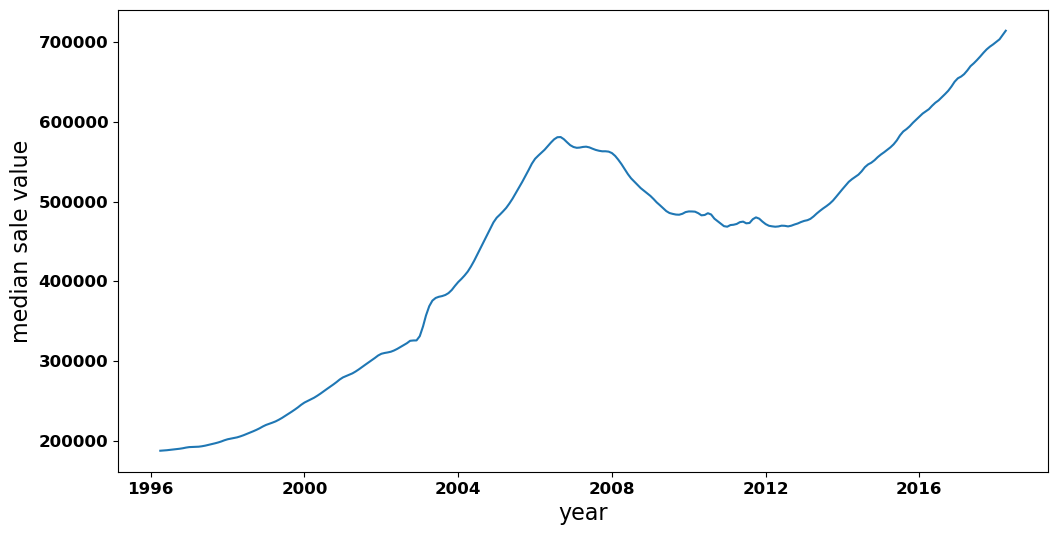

In [131]:
fig = plt.figure(figsize=(12, 6))
plt.plot(queens_ts)
plt.xlabel("year", fontsize=16)
plt.ylabel("median sale value", fontsize=16)
plt.show();

Let's get a view of the median housing sales values over time for each zipcode.

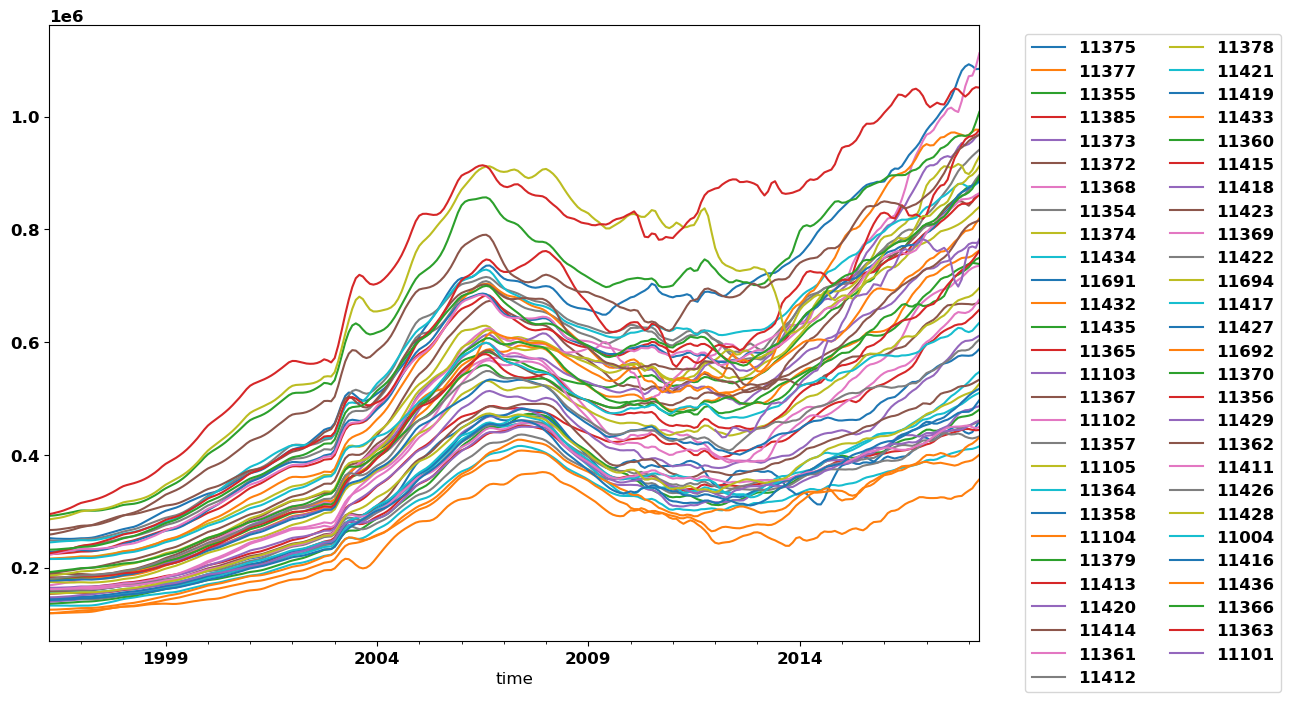

In [132]:
plt.figure(figsize=(12,8))
for zipcode in queens_melted_long.RegionName.unique():
    queens_melted_long.loc[queens_melted_long['RegionName'] == zipcode].value.plot(label=zipcode)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.show();

It looks like every zipcode within the county is following a very similar trend even though they have varying sales values.

## Dickey-Fuller Test

Both graphs show an upwards trend so it may not be stationary. Let's use the Dickey Fuller test to double check.

In [133]:
#queenstest = adfuller(queens_ts)
#display(queenstest)

In [134]:
# Dickey Fuller Text
queenstest = adfuller(queens_ts)

dfoutput = pd.Series(
                queenstest[0:4], 
                index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']
)

for key,value in queenstest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
display(dfoutput)

Test Statistic                  -1.328319
p-value                          0.616119
#Lags Used                      13.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64

The p-value is 0.616. Since it's quite a large number compared to an alpha value of 0.05, it can be concluded that this is not stationary.

In [135]:
queens_test = adfuller(queens_ts)[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {queens_test},")
if queens_test < 0.05:
    print(" therefore we can safely assume that the dataset is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that the dataset is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.6161187625692026,
 therefore we cannot reject the null hypothesis that the dataset is not stationary.


In [136]:
queens_ts

,value
time,
1996-04-01,187170.370370
1996-05-01,187407.407407
1996-06-01,187785.185185
1996-07-01,188238.888889
1996-08-01,188712.962963
...,...
2017-12-01,697172.727273
2018-01-01,700394.545455
2018-02-01,703658.181818


In [137]:
index = pd.DatetimeIndex(get_datetimes(queens))
index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [138]:
queens_ts

,value
time,
1996-04-01,187170.370370
1996-05-01,187407.407407
1996-06-01,187785.185185
1996-07-01,188238.888889
1996-08-01,188712.962963
...,...
2017-12-01,697172.727273
2018-01-01,700394.545455
2018-02-01,703658.181818


# Stationarity Tests
Before we proceed with our forecasting model, we first have to make sure that our dataset is stationary. 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


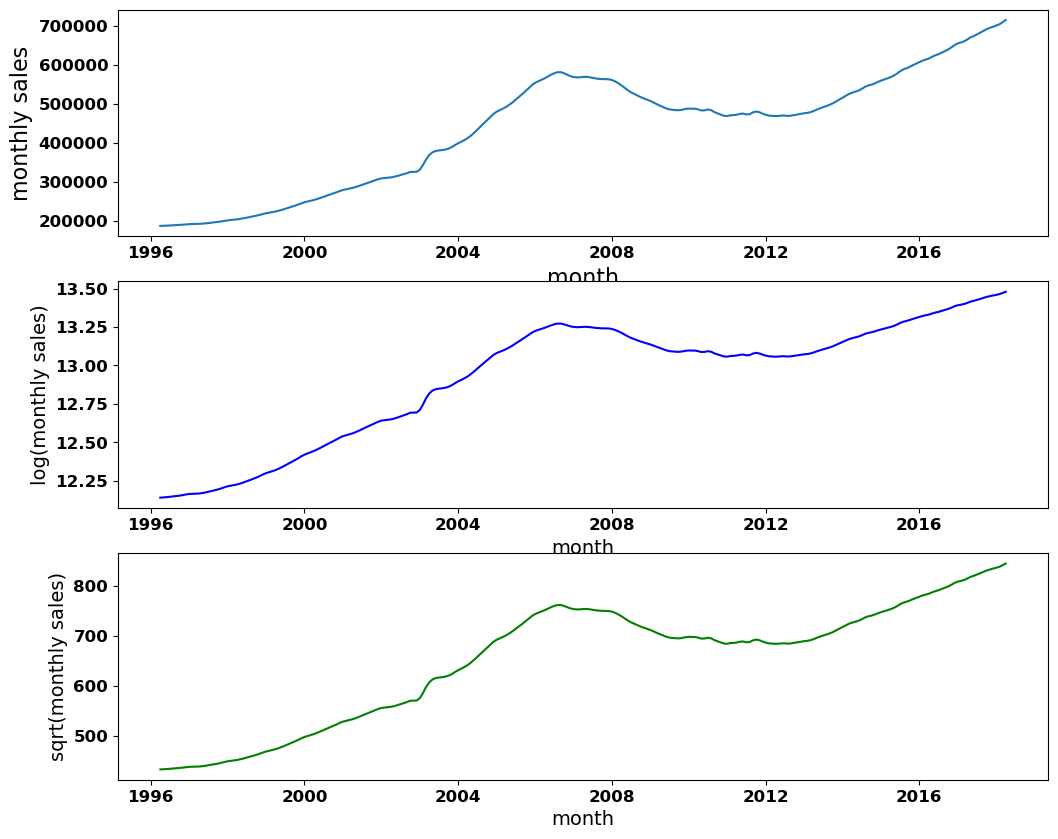

In [139]:
fig = plt.figure(figsize=(12, 10))


# No transformation
plt.subplot(3, 1, 1)
plt.plot(queens_ts)
plt.xlabel("month", fontsize=16)
plt.ylabel("monthly sales", fontsize=16)

# Log transformation (linear and heteroscedastic)
plt.subplot(3, 1, 2)
plt.plot(pd.Series(np.log(queens_ts['value']), index=index), color="blue") #log transformation with np.log()
plt.xlabel("month", fontsize=14)
plt.ylabel("log(monthly sales)", fontsize=14)

# Square root transformation 
plt.subplot(3, 1, 3)
plt.plot(pd.Series(np.sqrt(queens_ts['value']), index=index), color="green") #sqrt transformation with np.sqrt()
plt.xlabel("month", fontsize=14)
plt.ylabel("sqrt(monthly sales)", fontsize=14)


plt.show()

### Log Transformation

In [140]:
#Log Transformation
log_q = pd.Series(np.log(queens_ts['value']))

log_test = adfuller(log_q)[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {log_test},")
if log_test < 0.05:
    print(" therefore we can safely assume that the log transformed data is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that the log transformed data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.23870449317803039,
 therefore we cannot reject the null hypothesis that the log transformed data is not stationary.


### Square Root Transformation

In [141]:
#Square Root Transformation
sqrt_q = pd.Series(np.sqrt(queens_ts['value']))

sqrt_test = adfuller(sqrt_q)[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {sqrt_test},")
if sqrt_test < 0.05:
    print(" therefore we can safely assume that the square root transformed data is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that the square root transformed data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.43901287882199846,
 therefore we cannot reject the null hypothesis that the square root transformed data is not stationary.


### Substracting the Rolling Mean

#### Rolling Statistics

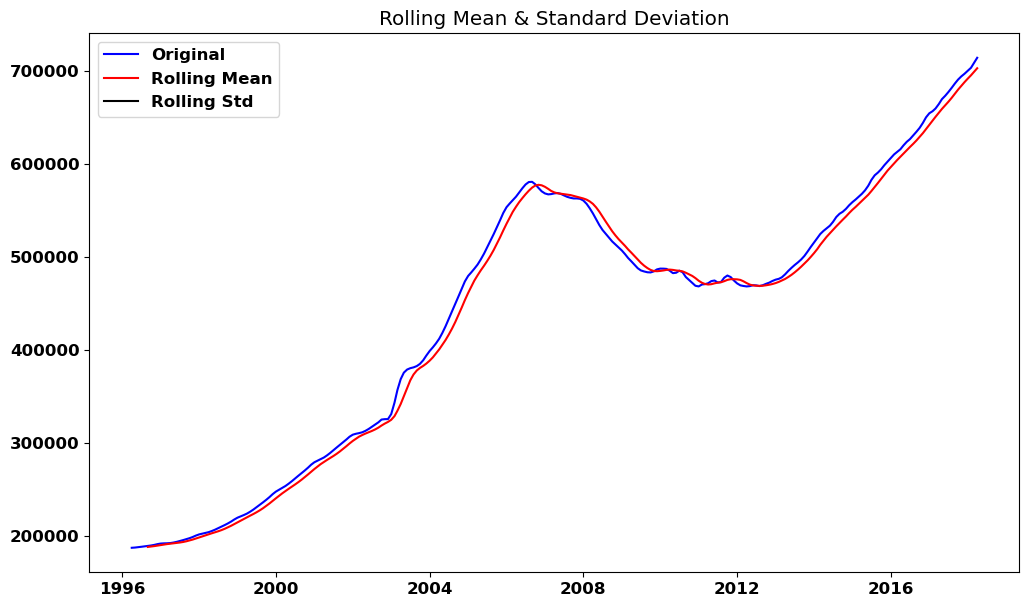

In [142]:
rolmean = queens_ts.rolling(window=6, center=False).mean() #rolling mean of 6 months --> call rolling function and do .mean()
rolstd = queens_ts.rolling(window=1, center=False).std() #rolling std of 1 month --> call rolling function and do .std()

fig = plt.figure(figsize=(12, 7))
orig = plt.plot(queens_ts, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

#### Using the Rolling Mean to Subtract from Time Series

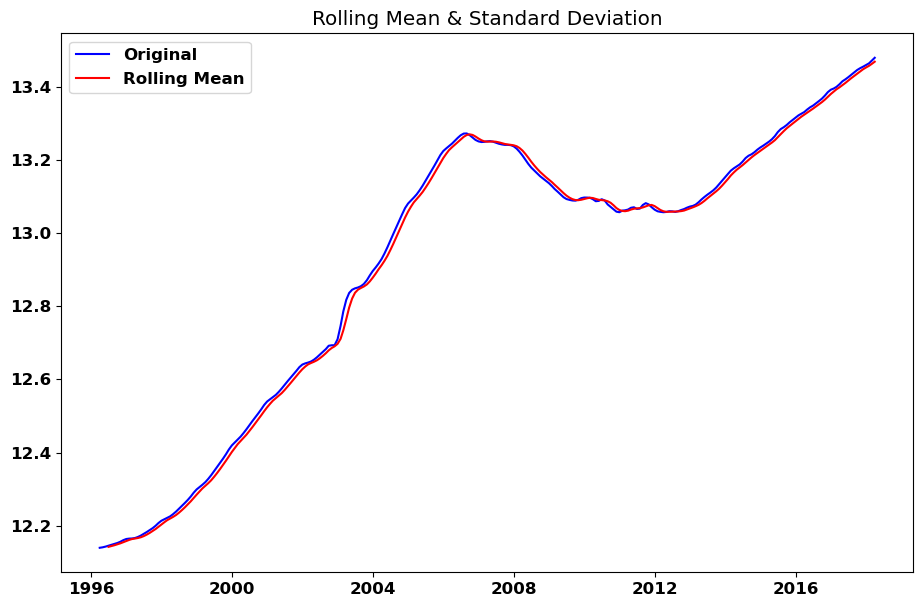

In [143]:
# Start with the log transform
data_transform = pd.Series(np.log(queens_ts['value']))

rolmean = data_transform.rolling(window=4).mean()
fig = plt.figure(figsize=(11, 7))
orig = plt.plot(data_transform, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [144]:
# Subtract the moving average from the original data and check head for Nans
data_minus_rolmean = data_transform - rolmean
data_minus_rolmean.head()

time
1996-04-01         NaN
1996-05-01         NaN
1996-06-01         NaN
1996-07-01    0.003133
1996-08-01    0.003597
Name: value, dtype: float64

In [145]:
# Drop the NaN values from timeseries calculated above 
# (the first few values didn't have a rolling mean)
data_minus_rolmean.dropna(inplace=True)
data_minus_rolmean

time
1996-07-01    0.003133
1996-08-01    0.003597
1996-09-01    0.003735
1996-10-01    0.003675
1996-11-01    0.004338
                ...   
2017-12-01    0.007019
2018-01-01    0.006705
2018-02-01    0.006790
2018-03-01    0.009011
2018-04-01    0.010698
Name: value, Length: 262, dtype: float64

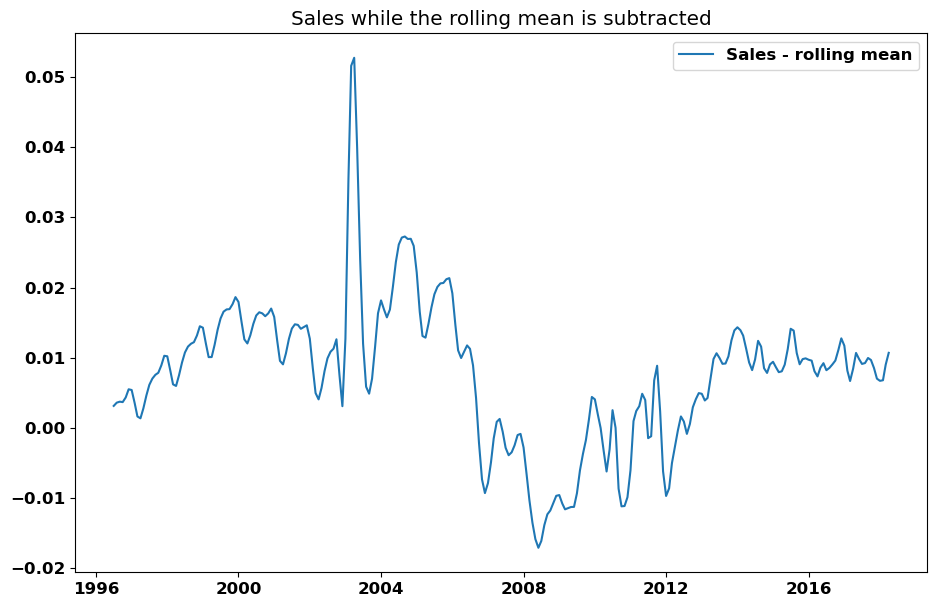

In [146]:
fig = plt.figure(figsize=(11, 7))
plt.plot(data_minus_rolmean, label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show(block=False)

In [147]:
# Print Dickey-Fuller test results
print ('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used',
                            'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -1.454086
p-value                          0.556090
#Lags Used                      14.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


In [148]:
rm_test = adfuller(data_minus_rolmean)[1]

print(f"The p-value associated with the Dickey-Fuller statistical test is {rm_test},")
if rm_test < 0.05:
    print(" therefore we can safely assume that subtracted rolling mean data is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that subtracted rolling mean data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.5560897448711815,
 therefore we cannot reject the null hypothesis that subtracted rolling mean data is not stationary.


### Differencing

In [149]:
diff = queens_ts.diff().dropna()

In [150]:
pd.DataFrame(np.hstack((queens_ts[1:].values.reshape(-1, 1),
                        diff.values.reshape(-1, 1))), columns=['orig', 'diff'])

,orig,diff
0,187407.407407,237.037037
1,187785.185185,377.777778
2,188238.888889,453.703704
3,188712.962963,474.074074
4,189185.185185,472.222222
...,...,...
259,697172.727273,2776.363636
260,700394.545455,3221.818182
261,703658.181818,3263.636364
262,708869.090909,5210.909091


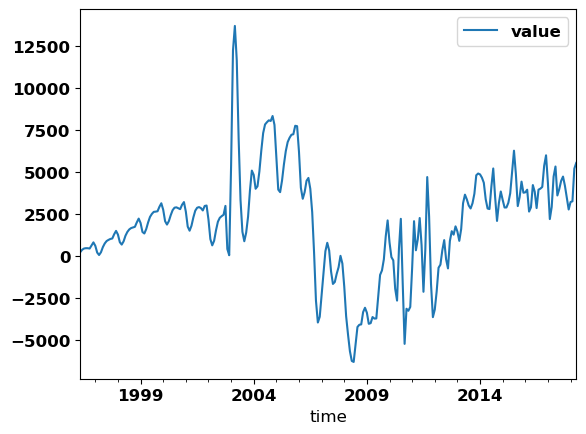

In [164]:
diff.plot();

In [166]:
p_val = adfuller(diff)[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val},")
if p_val < 0.05:
    print(" therefore we can safely assume that the differenced data is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.4883769511850005,
 therefore we cannot reject the null hypothesis that the differenced data is not stationary.


## Time Series Decomposition

#### Method 1

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


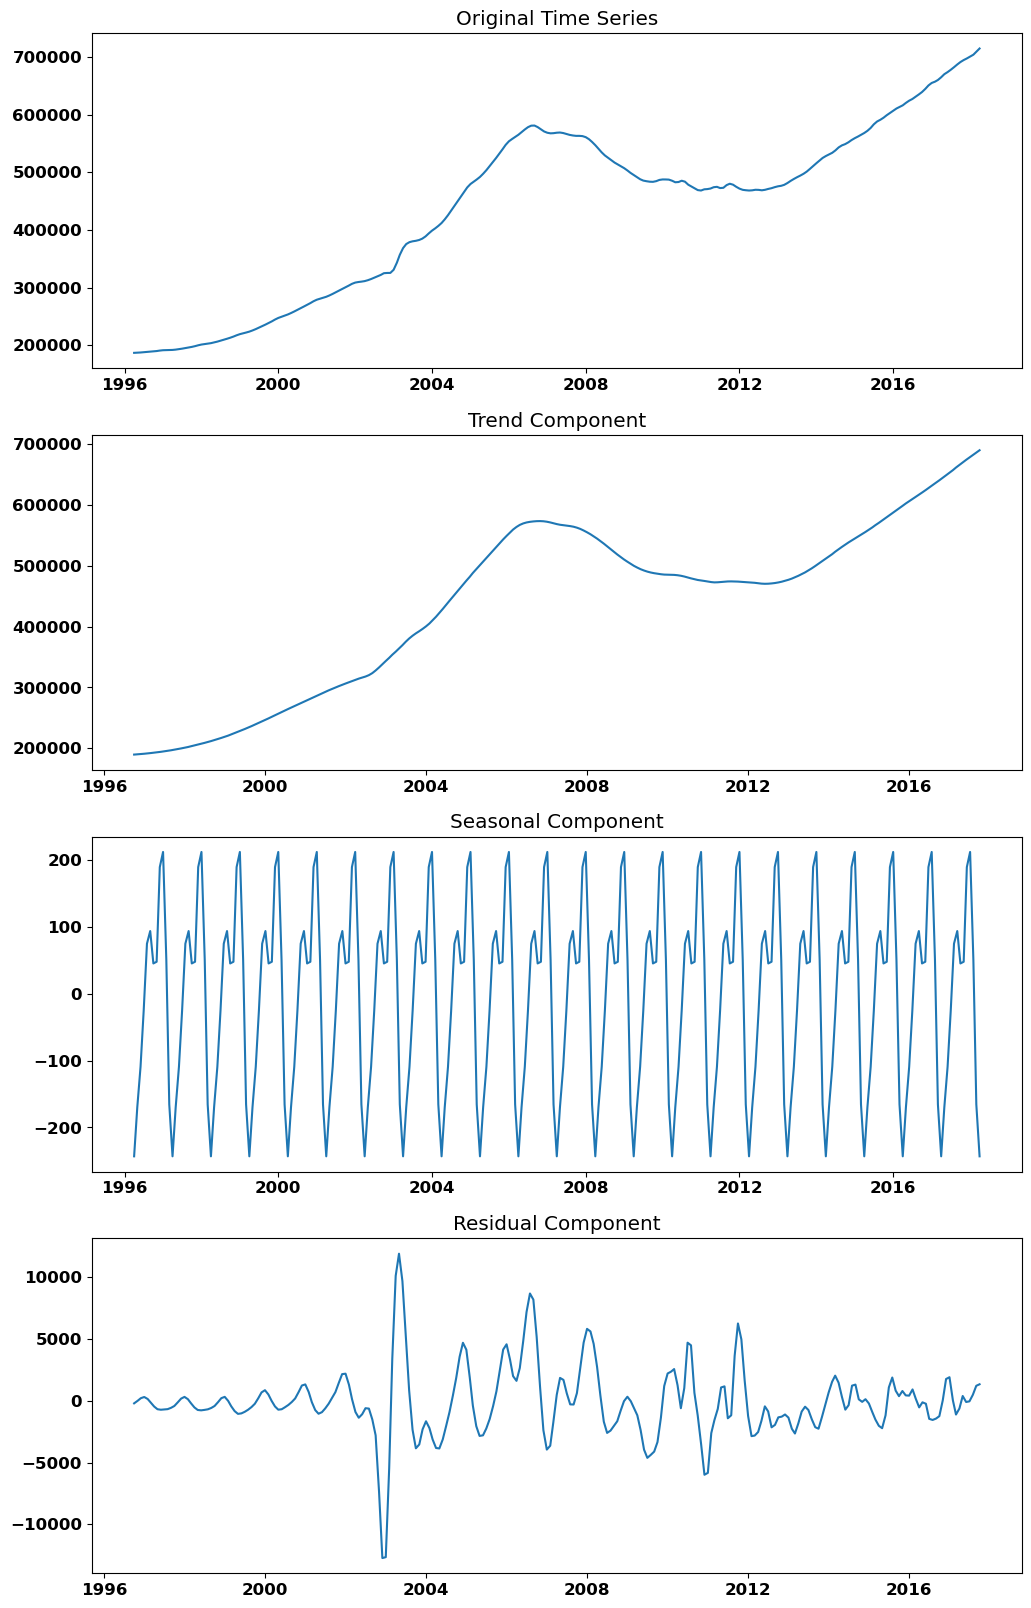

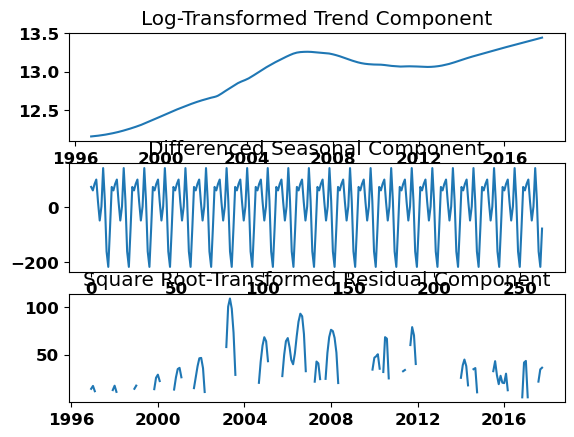

In [152]:
fig = plt.figure(figsize=(12, 20))

# Apply decomposition to separate the time series into trend, seasonal, and residual components
decomp = seasonal_decompose(queens_ts, model='additive', period=12) # Change period according to seasonality

# Plot the original time series and the decomposed components
plt.subplot(4, 1, 1)
plt.plot(queens_ts)
plt.title('Original Time Series')

plt.subplot(4, 1, 2)
plt.plot(decomp.trend)
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(decomp.seasonal)
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(decomp.resid)
plt.title('Residual Component')

# Apply different transformations to each component
trend_transformed = np.log(decomp.trend)
seasonal_transformed = np.diff(decomp.seasonal, n=1)
residual_transformed = np.sqrt(decomp.resid)

# Plot the transformed components
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(trend_transformed)
plt.title('Log-Transformed Trend Component')

plt.subplot(3, 1, 2)
plt.plot(seasonal_transformed)
plt.title('Differenced Seasonal Component')

plt.subplot(3, 1, 3)
plt.plot(residual_transformed)
plt.title('Square Root-Transformed Residual Component')

plt.show()


In [153]:
#Differenced Seasonal Component Transformation
dst_q = pd.Series(seasonal_transformed)

dst_test = adfuller(dst_q)[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {dst_test},")
if dst_test < 0.05:
    print(" therefore we can safely assume that the square root transformed data is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that the square root transformed data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.0,
 therefore we can safely assume that the square root transformed data is stationary.


In [154]:
dst_test = adfuller(dst_q)
dst_test

(-2750321943392838.0,
 0.0,
 15,
 248,
 {'1%': -3.4569962781990573,
  '5%': -2.8732659015936024,
  '10%': -2.573018897632674},
 -14139.731051598641)

#### Method 2

In [155]:
# Using log transformation as it decreased the p-value the most of the previous transformations
decomposition = seasonal_decompose(np.log(queens_ts))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

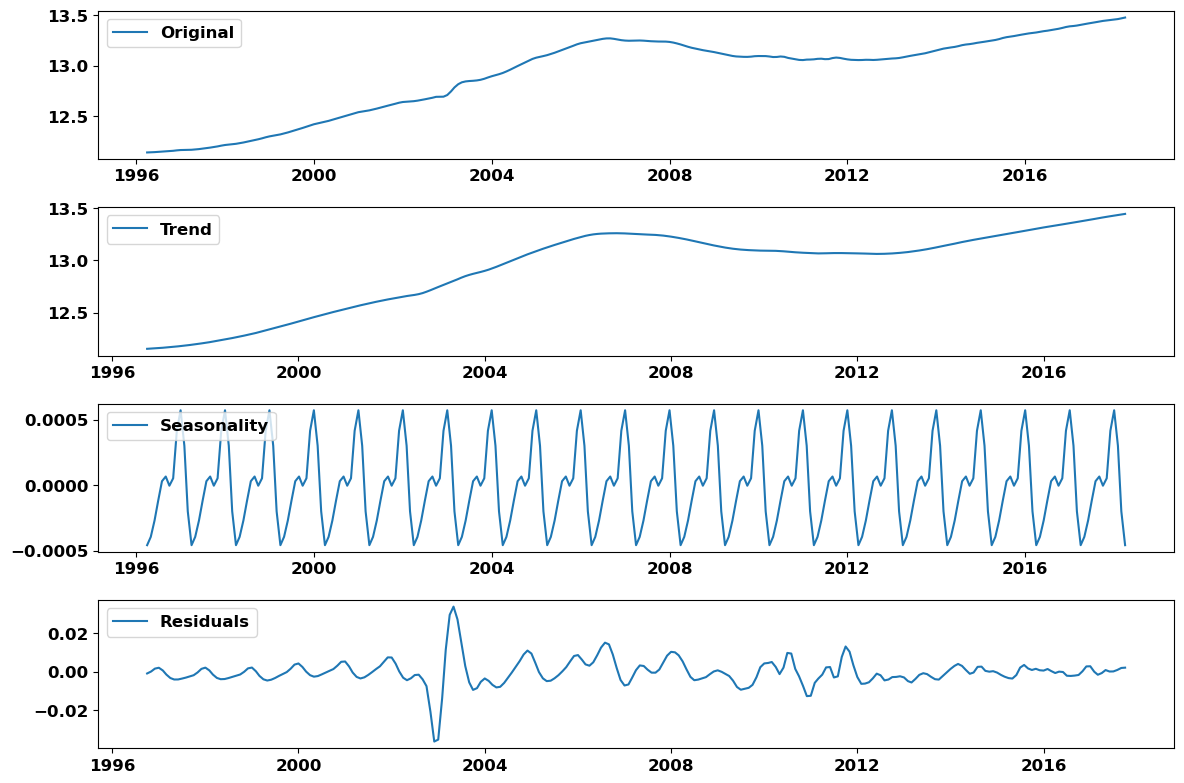

In [156]:
# Plot gathered statistics
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(np.log(queens_ts), label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()

In [157]:
# Drop NaN values from residuals.
ts_log_decompose = residual
ts_log_decompose = ts_log_decompose.dropna()

In [158]:
# Print Dickey-Fuller test results
dftest = adfuller(ts_log_decompose)

print ('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used',
                            'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -3.722662
p-value                          0.003805
#Lags Used                      14.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


In [159]:
#Differenced Seasonal Component Transformation

dftest = adfuller(ts_log_decompose)[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {dftest},")
if dftest < 0.05:
    print(" therefore we can safely assume that the seasonally differenced data is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that the seasonally differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.00380544581086113,
 therefore we can safely assume that the seasonally differenced data is stationary.


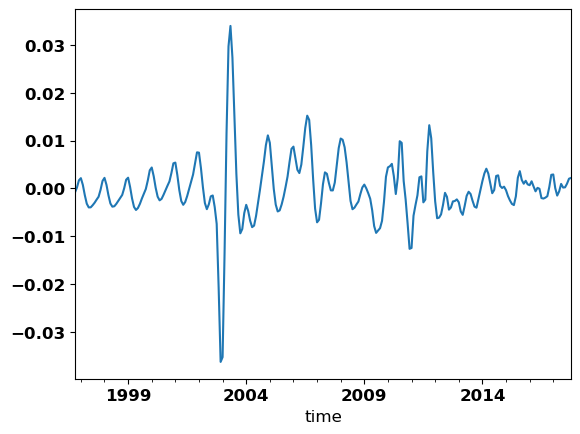

In [160]:
ts_log_decompose.plot();

## Train Test Split

In [161]:
# find the index which allows us to split off 20% of the data
cutoff = round(queens_ts.shape[0]*0.8) #cut off point at 80% of the data
cutoff

212

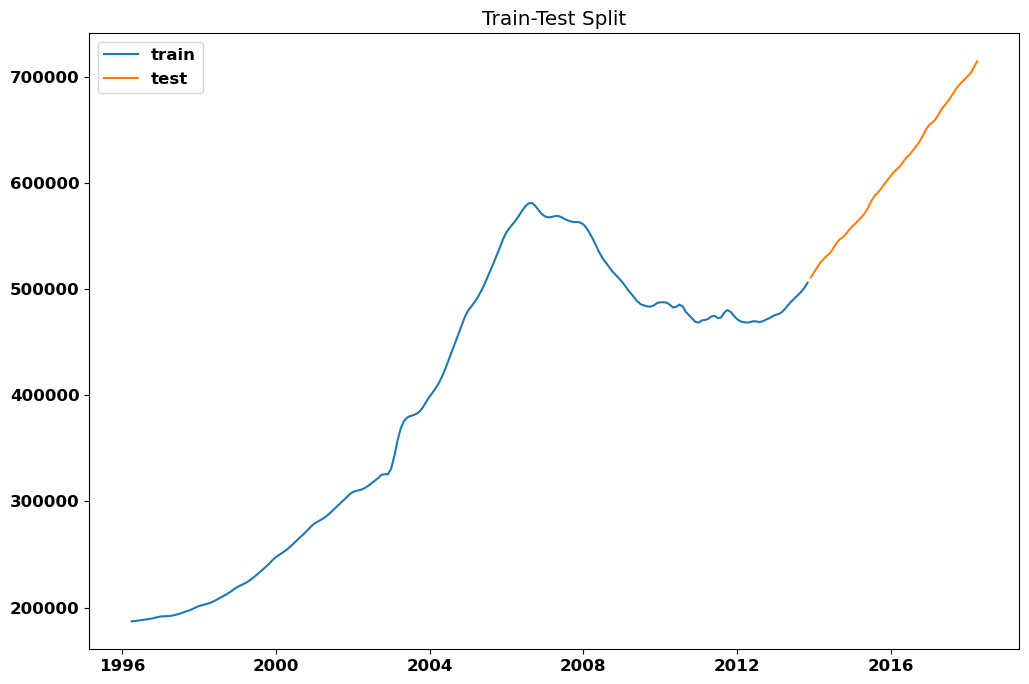

In [162]:
# Define train and test sets according to the index found above
train = queens_ts[:cutoff] #before cut off is train set -- 80%

test = queens_ts[cutoff:] #after cut off is the test set --20%

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

# TimeSeriesSplit ? 

In [138]:
split = TimeSeriesSplit()


## Baseline Model

The baseline model has just one time period shift in our dataset.

In [139]:
train

,value
time,
1996-04-01,187170.370370
1996-05-01,187407.407407
1996-06-01,187785.185185
1996-07-01,188238.888889
1996-08-01,188712.962963
...,...
2013-07-01,491392.727273
2013-08-01,494230.909091
2013-09-01,497376.363636


In [140]:
test

,value
time,
2013-12-01,510823.636364
2014-01-01,515689.090909
2014-02-01,520361.818182
2014-03-01,524730.909091
2014-04-01,528118.181818
2014-05-01,530954.545455
2014-06-01,533756.363636
2014-07-01,537881.818182
2014-08-01,543100.000000


In [141]:
# we can perform this with the shift operator
# The prediction for the next day is the original series shifted to the future by one day.
naive = train.shift(1)
naive

,value
time,
1996-04-01,NaN
1996-05-01,187170.370370
1996-06-01,187407.407407
1996-07-01,187785.185185
1996-08-01,188238.888889
...,...
2013-07-01,488380.000000
2013-08-01,491392.727273
2013-09-01,494230.909091


Let's take a look at a shift of one time period over.

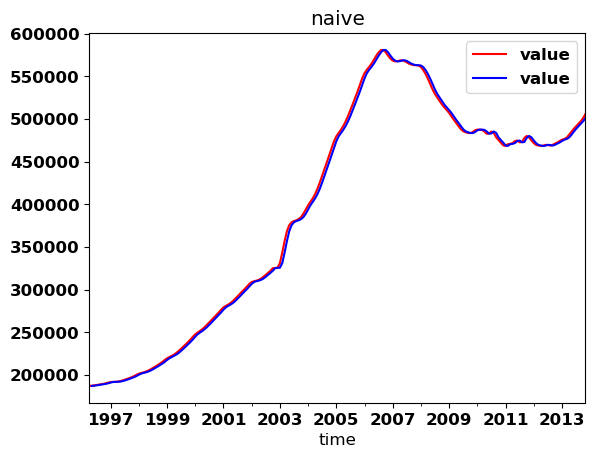

In [142]:
fig, ax = plt.subplots()

train.plot(ax=ax, c='r', label='original')
naive.plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

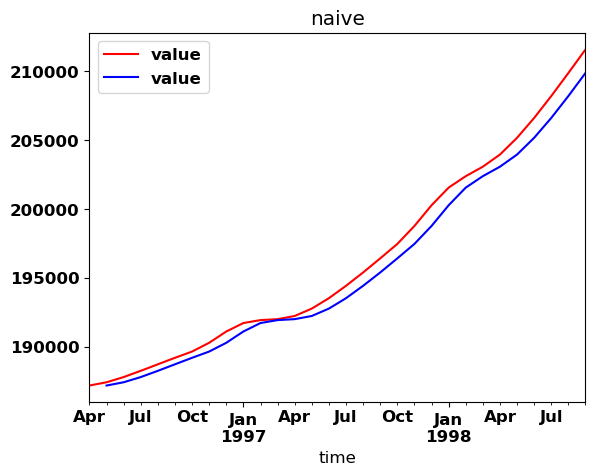

In [143]:
#A closer look
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

For a baseline to compare our later models, lets calculate our RMSE for the naive model.

In [144]:
np.sqrt(mean_squared_error(train[1:], naive.dropna()))

3619.7586403410414

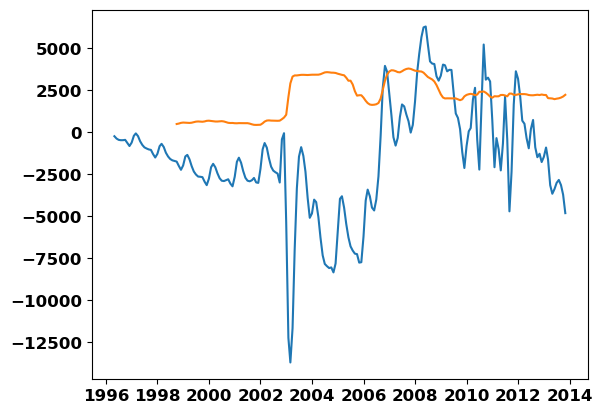

In [145]:
fig, ax = plt.subplots()
residuals = naive[1:] - train[1:] #shift minus the train
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

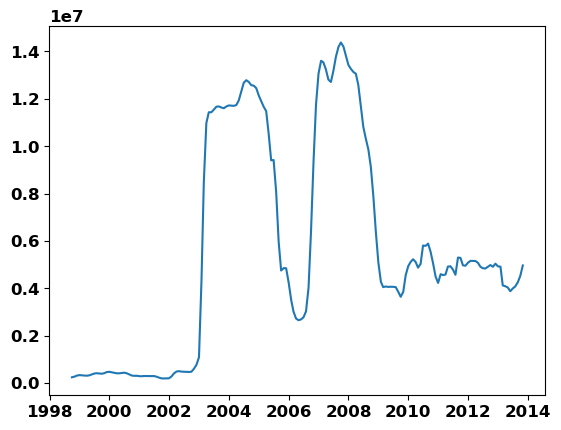

In [146]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

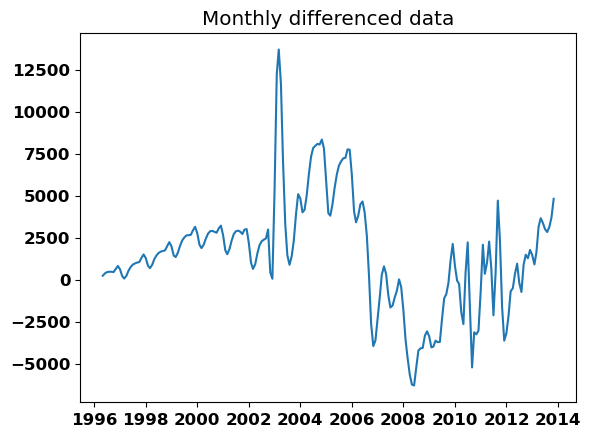

In [147]:
fig, ax = plt.subplots()
ax.plot(train.diff())  #taking the differnce
ax.set_title('Monthly differenced data');

In [148]:
p_val = adfuller(train.diff()[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val},")
if p_val < 0.05:
    print(" therefore we can safely assume that the differenced data is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.5624888197389685,
 therefore we cannot reject the null hypothesis that the differenced data is not stationary.


# Step 5: ARIMA Modeling

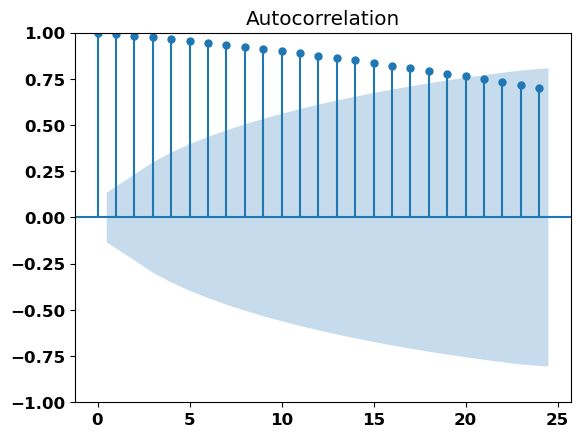

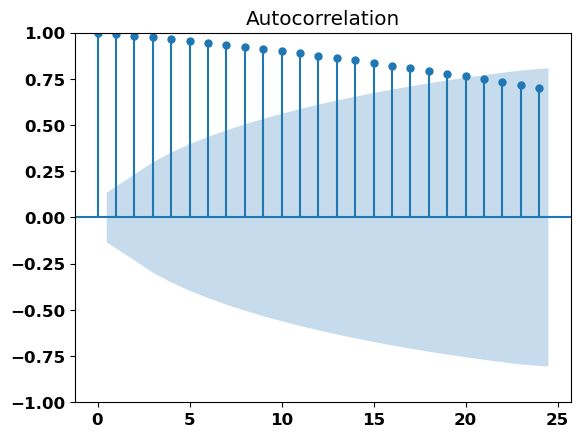

In [149]:
#Plot_acf is used to identify the q parameter
plot_acf(train)

check q -- 19, 20, 21

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


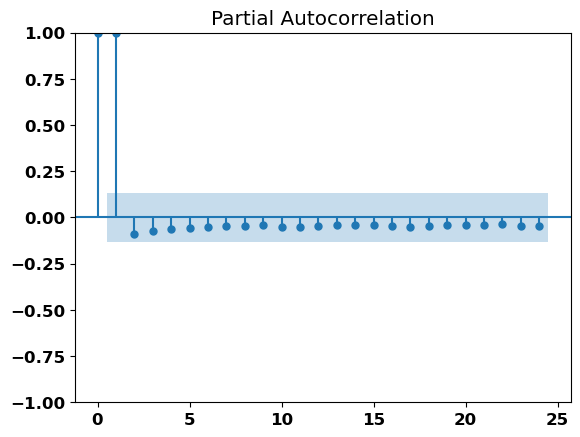

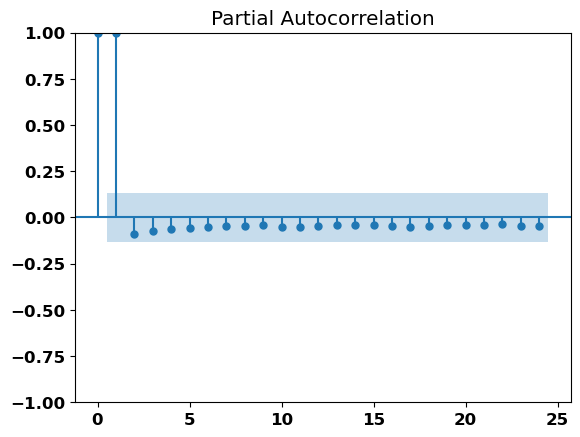

In [150]:
##plot_acf is used to identify the p parameter 
plot_pacf(train)

check p parameter value of 2 and 3 

# FOR ARIMA MODEL
p = 2, 3
d = 0
q = 20, 21

## Autoregressive Model (AR)

In [151]:
ar_1 = ARIMA(train, order=(2, 1, 20)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1996-04-01         0.000000
1996-05-01    199766.404200
1996-06-01    194619.712869
1996-07-01    192538.067876
1996-08-01    192571.731403
                  ...      
2013-07-01    489889.213929
2013-08-01    492042.987308
2013-09-01    495968.819426
2013-10-01    498118.703580
2013-11-01    502759.405340
Freq: MS, Name: predicted_mean, Length: 212, dtype: float64

In [152]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  212
Model:                ARIMA(2, 1, 20)   Log Likelihood               -2829.616
Date:                Mon, 27 Mar 2023   AIC                           5705.233
Time:                        00:25:36   BIC                           5782.326
Sample:                    04-01-1996   HQIC                          5736.395
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4335      0.020     21.809      0.000       0.395       0.472
ar.L2          0.5544      0.020     27.708      0.000       0.515       0.594
ma.L1         -0.2471      0.021    -11.870      0.000      -0.288      -0.206
ma.L2         -0.6045      0.018    -34.480      0.000      -0.639      -0.570
ma.L3         -0.0605      0.004    -13.991      0.000      -0.069      -0.052
ma.L4          0.0377      0.006      6.543      0.000       0.026       0.049
ma.L5         -0.1068      0.012     -9.125      0.000      -0.130      -0.084
ma.L6          0.0988      0.008     13.159      0.000       0.084       0.114
ma.L7         -0.0754      0.014     -5.577      0.000      -0.102      -0.049
ma.L8          0.0621      0.005     12.214      0.000       0.052       0.072
ma.L9         -0.0128      0.012     -1.093      0.274      -0.036       0.010
ma.L10        -0.0507      0.007     -6.788      0.000      -0.065      -0.036
ma.L11         0.0632      0.007      9.584      0.000       0.050       0.076
ma.L12        -0.1085      0.007    -16.532      0.000      -0.121      -0.096
ma.L13         0.1001      0.005     19.750      0.000       0.090       0.110
ma.L14        -0.0596      0.005    -11.315      0.000      -0.070      -0.049
ma.L15         0.0467      0.004     11.438      0.000       0.039       0.055
ma.L16         0.0181      0.009      2.043      0.041       0.001       0.035
ma.L17        -0.0565      0.007     -7.953      0.000      -0.070      -0.043
ma.L18         0.0957      0.005     18.439      0.000       0.086       0.106
ma.L19        -0.1327      0.004    -32.388      0.000      -0.141      -0.125
ma.L20         0.0288      0.004      8.064      0.000       0.022       0.036
sigma2      8.813e+05   3.34e-08   2.64e+13      0.000    8.81e+05    8.81e+05
===================================================================================
Ljung-Box (L1) (Q):                  19.46   Jarque-Bera (JB):                16.30
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.45e+28. Standard errors may be unstable.
"""

In [ ]:
ar_1.aic

## Random Walk

In [ ]:
random_walk_model = ARIMA(train, order=(0, 1, 0)).fit() #random walk model - making it stationary by taking difference 
random_walk_model.summary()

In [ ]:
print(f'Random Walk AIC: {random_walk_model.aic}')
print(f'AR(1, 1, 0) AIC: {ar_1.aic}' )

#### RMSE: Random Walk vs AR1

In [ ]:
y_hat_ar1 = ar_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1)) #ar1 RMSE

In [ ]:
y_hat_rw = random_walk_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_rw)) #random walk RMSE

The random walk model has a higher RMSE, therefore, it performed worse.

# Step 6: Interpreting Results

In [90]:
queens_melted_long

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,value
time,,,,,,,,
1996-04-01,11375,62087,13,New York,NY,New York,Queens,252400.0
1996-04-01,11377,62088,86,New York,NY,New York,Queens,179000.0
1996-04-01,11355,62067,100,New York,NY,New York,Queens,182800.0
1996-04-01,11385,62093,139,New York,NY,New York,Queens,160600.0
1996-04-01,11373,62085,141,New York,NY,New York,Queens,175400.0
...,...,...,...,...,...,...,...,...
2018-04-01,11004,61979,7725,New York,NY,New York,Queens,634300.0
2018-04-01,11416,62102,8008,New York,NY,New York,Queens,517300.0
2018-04-01,11436,62122,8009,New York,NY,New York,Queens,400300.0


# Other Graphs

In [86]:
#Calculate the Median Sales Value Grouped By Zipcode 
queens_zip_median = queens_melted_long.groupby('RegionName').median()

#Sort Descending by Value and fixate on top 10 only
top10 = queens_zip_median.sort_values(by='value', ascending=False)[:10]

#drop non relevant rows
top10 = top10.drop(['RegionID', 'SizeRank'], axis=1)
top10

,value
RegionName,
11363,818400.0
11694,724500.0
11360,710500.0
11362,679700.0
11375,675000.0
11101,650800.0
11364,619600.0
11357,611700.0
11415,609600.0


In [91]:
#Calculate the Mean Sales Value Grouped By Zipcode 
queens_zip_mean = queens_melted_long.groupby('RegionName').mean()

#Sort Descending by Value and fixate on top 10 only
top10_mean = queens_zip_mean.sort_values(by='value', ascending=False)[:10]

#drop non relevant rows
top10_mean = top10_mean.drop(['RegionID', 'SizeRank'], axis=1)
top10_mean

,value
RegionName,
11363,735301.132075
11694,663121.509434
11360,656026.415094
11101,621317.105263
11362,615289.811321
11375,608116.981132
11415,569556.981132
11364,565133.962264
11357,556736.603774


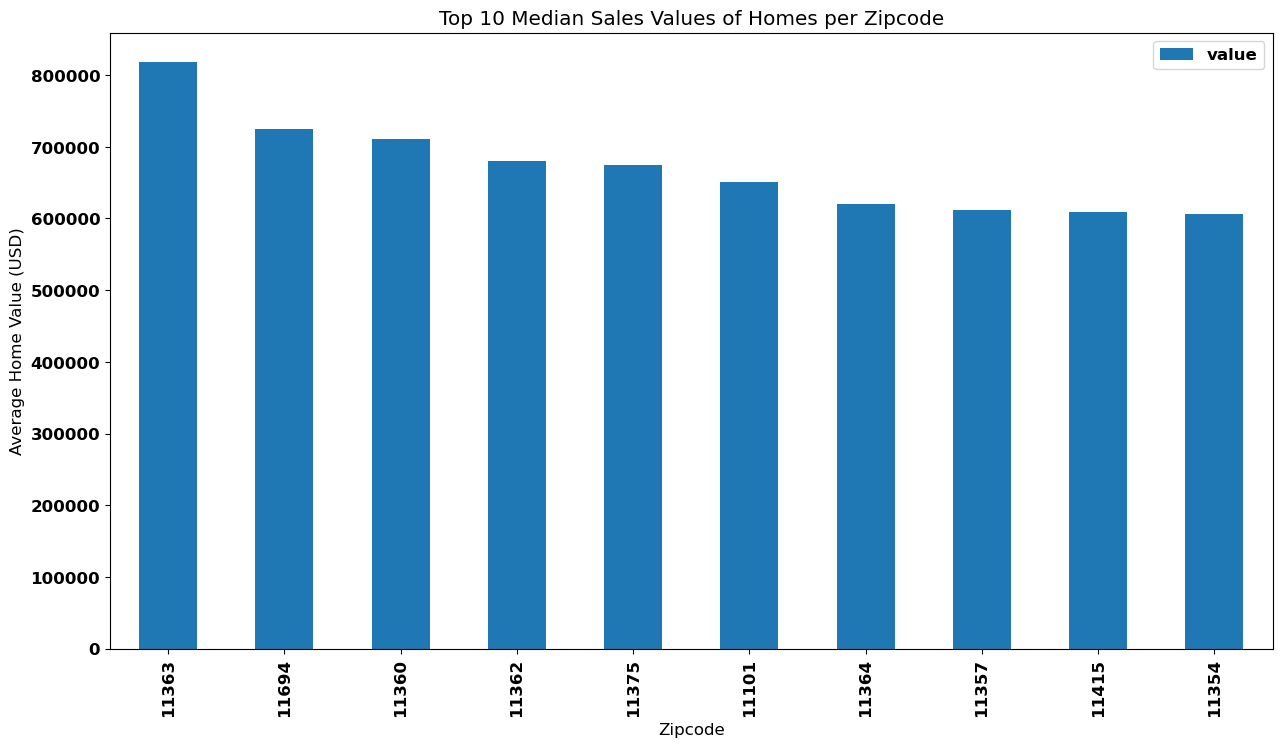

In [87]:
top10.plot(kind='bar',figsize=(15,8))
plt.title("Top 10 Median Sales Values of Homes per Zipcode")
plt.xlabel("Zipcode")
plt.ylabel("Average Home Value (USD)")
plt.plot();

In [ ]:
top10_zips = 11363, 11694, 11360, 11101, 11362, 11375, 11415, 11364, 11357, 11354

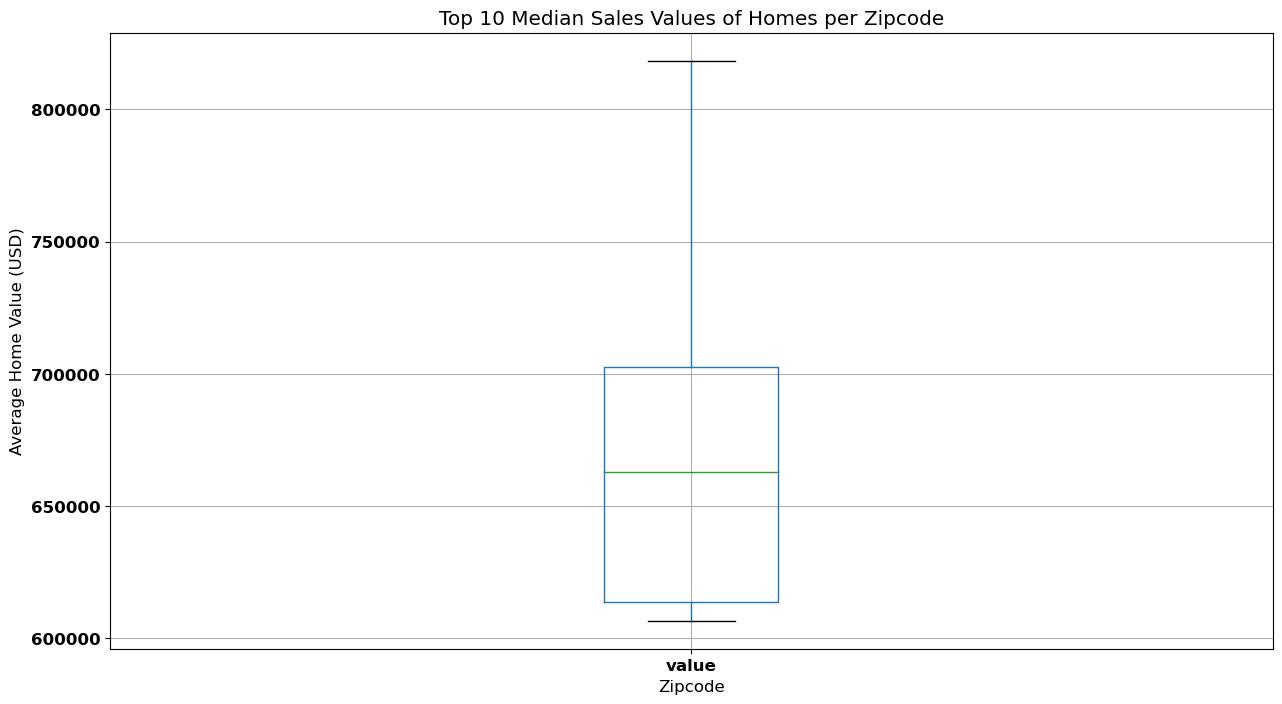

In [89]:
top10.boxplot(figsize=(15,8))
plt.title("Top 10 Median Sales Values of Homes per Zipcode")
plt.xlabel("Zipcode")
plt.ylabel("Average Home Value (USD)")
plt.plot();